# Dyna Q

We can interleave a model-free method (e.g. Q-learning) and a planning method (e.g. value iteration)

Consider the Slippery Walk Seven (SWS) environment in order to apply the algorithm.

In [1]:
import numpy as np
import random

class Space:
    def __init__(self, value):
        self.n = value
    
class SlipperyWalk:
    def __init__(self):
        self.reset()

    def reset(self):
        self.observation_space = Space(9)
        self.action_space = Space(2)
        self._state = np.random.choice([1,2,3,4,5,6,7])
        self._done = False
        return self._state

    def step(self, action):
        if self._done: raise ValueError('Episode has terminated')
        if action not in [0, 1]: raise ValueError('Invalid action')
        
        if(action==0): direction = -1
        if(action==1): direction = 1
        
        direction_list = [direction, -direction, 0]
        true_direction = random.choices(direction_list, weights=(50, 17, 33), k=1)
        self._state += true_direction[0]
        
        reward = 0
        if self._state < 1: self._done = True
        if self._state > 7: self._done = True; reward = 1
        return self._state, reward, self._done, 0  # obs, rew, done

In [2]:
env = SlipperyWalk()

In [3]:
optimal_V = [0., 0.5637, 0.763, 0.8449, 0.8892, 0.922, 0.9515, 0.9806, 0.] 

We can write the algoritms in Python:

In [4]:
def decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

In [5]:
def dyna_q(env, gamma=1.0,
           init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
           init_epsilon=1.0, min_epsilon=0.1, epsilon_decay_ratio=0.9,
           n_planning=3, n_episodes=3000):
    
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track =[]
   
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    
    # create a function to keep track of the transition function
    # and another one to keep track of the reward signal.
    T_count = np.zeros((nS, nA, nS), dtype=int)
    R_model = np.zeros((nS, nA, nS), dtype=np.float64)
    T_track, R_track, planning_track = [], [], []
    
    select_action = lambda state, Q, epsilon: \
        np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)
    
    # the episode loop
    for e in range(n_episodes):
                   
        state, done = env.reset(), False
        
        while not done:
                   
            # select the action, as in original Q-learning       
            action = select_action(state, Q, epsilons[e])
                   
            # step the environment and get the experience tuple
            next_state, reward, done, _ = env.step(action)

            # start learning the model! 
            # increment the transition count for the state-action-next_state triplet 
            T_count[state][action][next_state] += 1
            
            # calculate an incremental mean of the reward signal
            # and use it to learn the reward signal
            r_diff = reward - R_model[state][action][next_state]
            R_model[state][action][next_state] += (r_diff / T_count[state][action][next_state])

            # calculate the TD target as usual, Q-learning style 
            # (off-policy, using the max)
            td_target = reward + gamma * Q[next_state].max() * (not done)
            
            # and the TD error
            td_error = td_target - Q[state][action]
            
            # finally, update the Q-function
            Q[state][action] = Q[state][action] + alphas[e] * td_error

            # get into the planning steps, first back up the next state variable.       
            backup_next_state = next_state
            
            # planning loop
            for _ in range(n_planning):
                   
                # make sure there have been updates to the Q-function before, 
                # otherwise, there’s not much to plan
                if Q.sum() == 0: break

                # select a state from a list of states already visited by 
                # the agent in experience   
                visited_states = np.where(np.sum(T_count, axis=(1, 2)) > 0)[0]
                state = np.random.choice(visited_states)

                # then select an action that has been taken on that state.   
                actions_taken = np.where(np.sum(T_count[state], axis=1) > 0)[0]
                action = np.random.choice(actions_taken)

                # use the count matrix to calculate probabilities of a next state 
                # and then a next state   
                probs = T_count[state][action]/T_count[state][action].sum()
                next_state = np.random.choice(np.arange(nS), size=1, p=probs)[0]
                
                # use the reward model as the reward
                reward = R_model[state][action][next_state]
                planning_track.append((state, action, reward, next_state))

                # update the Q-function using that simulated experience!    
                td_target = reward + gamma * Q[next_state].max()
                td_error = td_target - Q[state][action]
                Q[state][action] = Q[state][action] + alphas[e] * td_error
            
            V = np.max(Q, axis=1)
            
            # at the end of the planning steps, set the state as the next state
            state = backup_next_state

        T_track.append(T_count.copy())
        R_track.append(R_model.copy())
        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, V_track, pi_track, T_track, R_track, np.array(planning_track)

In [6]:
Q_dyna, V_dyna, pi_dyna, Q_track_dq, V_track_dq, pi_track_dq, T_track_dq, R_track_dq, planning_dq = dyna_q(env)

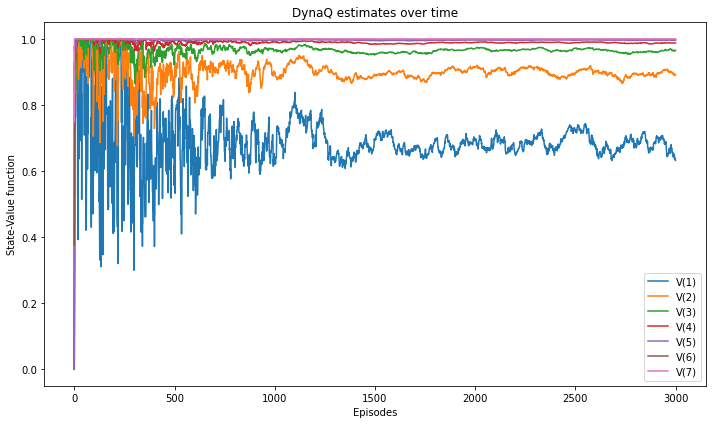

In [7]:
import matplotlib.pyplot as plt

legends = ['V(1)','V(2)','V(3)','V(4)','V(5)', 'V(6)', 'V(7)']

plt.figure(figsize=(10,6))
plt.plot(V_track_dq[:,1:8])
plt.title('DynaQ estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)
plt.tight_layout()
plt.show()

We can plot the learned transition model:

In [13]:
np.seterr(invalid='ignore')

def plot_transition_model(T_track, episode = 0):
    
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=20, azim=50)

    color_left, color_right = '#008fd5', '#fc4f30'

    left_prob = np.divide(T_track[episode][:,0].T, T_track[episode][:,0].sum(axis=1).T).T
    left_prob = np.nan_to_num(left_prob, 0)
    right_prob = np.divide(T_track[episode][:,1].T, T_track[episode][:,1].sum(axis=1).T).T
    right_prob = np.nan_to_num(right_prob, 0)

    for s in np.arange(9):
        ax.bar3d(s+0.1, np.arange(9)+0.1, np.zeros(9), np.zeros(9)+0.3, np.zeros(9)+0.3, 
                 left_prob[s], color=color_left, alpha=0.75, shade=True)
        ax.bar3d(s+0.1, np.arange(9)+0.1, left_prob[s], np.zeros(9)+0.3, np.zeros(9)+0.3, 
                 right_prob[s], color=color_right, alpha=0.75, shade=True)

    ax.tick_params(axis='x', which='major', pad=10)
    ax.tick_params(axis='y', which='major', pad=10)
    ax.tick_params(axis='z', which='major', pad=10)

    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    
    ax.set_xticks(np.arange(9))
    ax.set_yticks(np.arange(9))

    plt.title('SWS learned MDP after {} episodes'.format(episode+1))
    ax.set_xlabel('Initial\nstate', labelpad=75, rotation=0)
    ax.set_ylabel('Landing\nstate', labelpad=75, rotation=0)
    ax.set_zlabel('Transition\nprobabilities', labelpad=75, rotation=0)

    left_proxy = plt.Rectangle((0, 0), 1, 1, fc=color_left)
    right_proxy = plt.Rectangle((0, 0), 1, 1, fc=color_right)

    plt.legend((left_proxy, right_proxy), ('Left', 'Right'), 
               bbox_to_anchor=(0.15, 0.9), borderaxespad=0.)

    ax.dist = 12
    plt.tight_layout()

    plt.show()

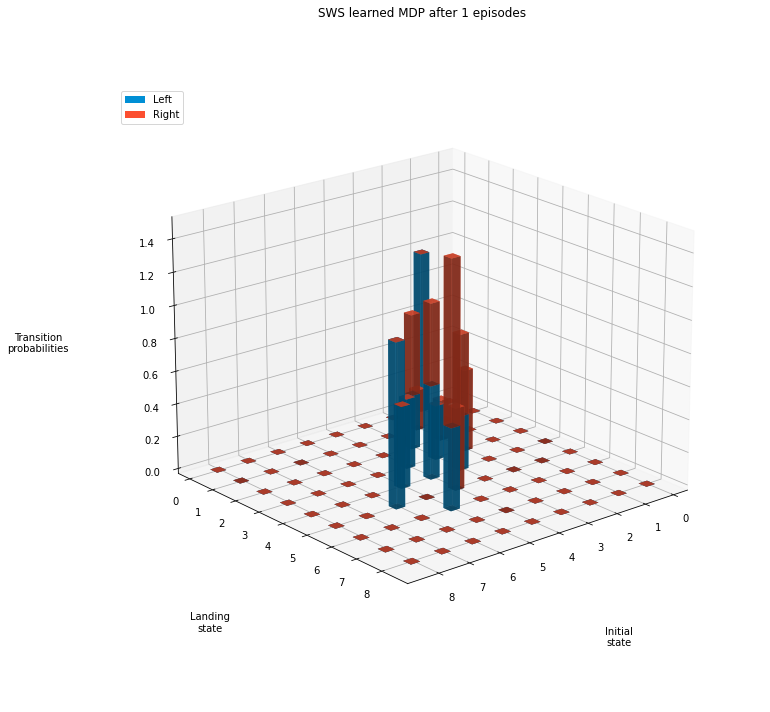

In [14]:
plot_transition_model(T_track_dq, episode=0)

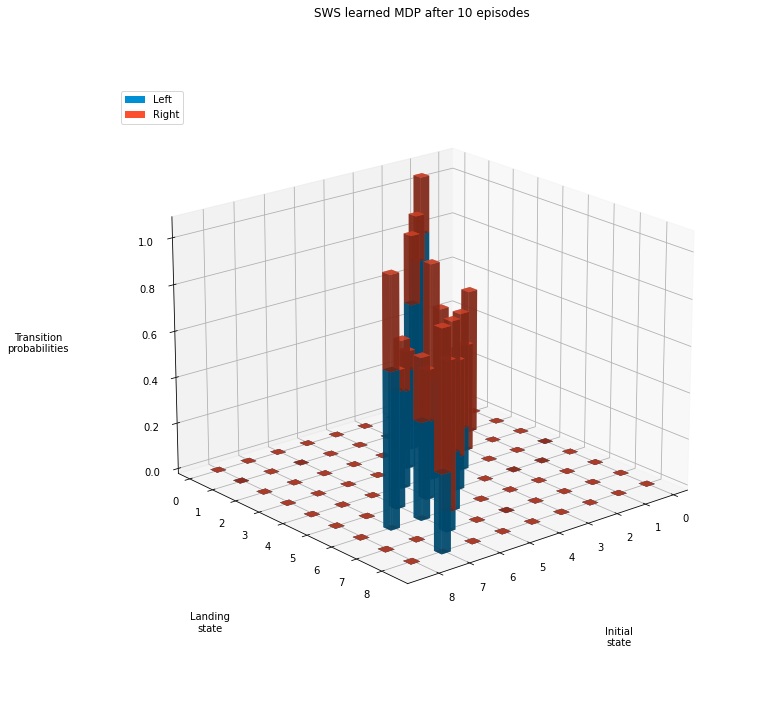

In [15]:
plot_transition_model(T_track_dq, episode=9)

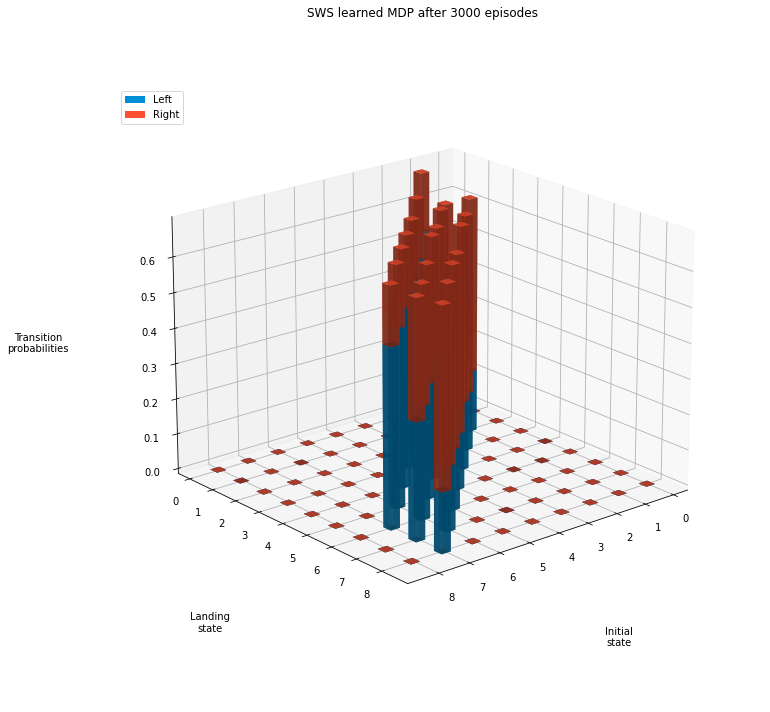

In [16]:
plot_transition_model(T_track_dq, episode=len(T_track_dq)-1)